In [11]:
map_scale = 4
p = 0.8
!optuna-dashboard sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_p_{p}.db

In [33]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optuna

In [34]:
def plot_accuracy_evolution(trial, label=""):
    def smooth(x, w=0.01):
        filter = jnp.ones(int(1 + w * len(x)))
        smoothed = jnp.convolve(jnp.array(x), filter / filter.sum(), mode="full")
        return smoothed[: len(x)]

    mean = smooth(trial.user_attrs["accuracy_evol_mean"])
    std = smooth(trial.user_attrs["accuracy_evol_std"])
    upper_bound = smooth(trial.user_attrs["accuracy_evol_max"])
    lower_bound = smooth(trial.user_attrs["accuracy_evol_min"])

    steps = jnp.arange(1, 1 + len(mean)) * trial.user_attrs["cycle_train_iter"]
    plt.plot(steps, mean, label=label)
    color = plt.gca().lines[-1].get_color()
    # plt.plot(smooth(mean+std), color=color, linestyle="--")
    # plt.plot(smooth(mean-std), color=color, linestyle="--")
    plt.fill_between(steps, smooth(upper_bound), smooth(lower_bound), alpha=0.3, color=color)

    stages_duration = trial.user_attrs["stages_duration"]
    for duration in jnp.cumsum(jnp.array(stages_duration)):
        plt.axvline(duration * trial.user_attrs["cycle_train_iter"], color="k", linestyle="--")
    

n_trials 256
n_trials 256


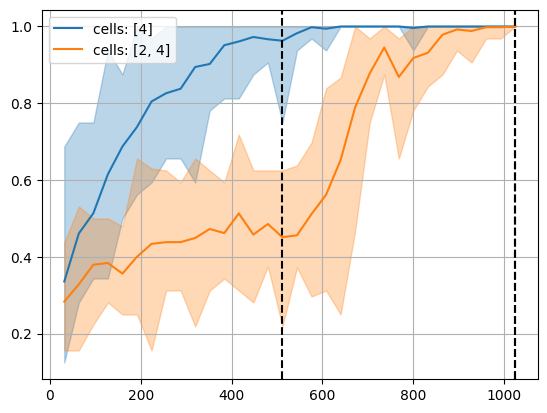

In [35]:
map_scale = 2
p = 0.8

storage_path = f"sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_p_{p}.db"
for cell_scales in [(map_scale,), tuple(range(1, map_scale + 1))]:
    study = optuna.load_study(study_name=f"mango_stages_{list(cell_scales)}", storage=storage_path)
    print("n_trials", len(study.trials))
    plot_accuracy_evolution(study.best_trial, label=f"cells: {[2**s for s in cell_scales]}")
plt.grid()
plt.legend()

n_trials 256
n_trials 256
n_trials 329


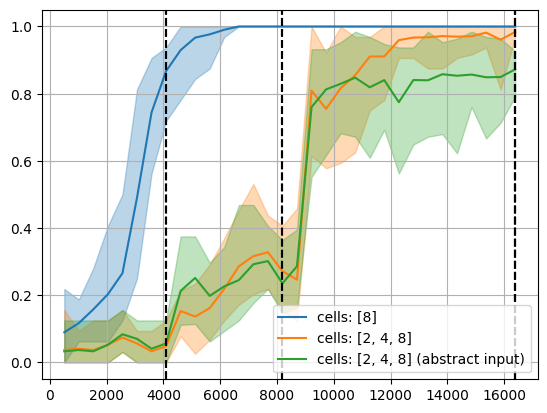

In [39]:
map_scale = 3
p = 0.8

storage_path = f"sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_p_{p}.db"
for cell_scales in [(map_scale,), tuple(range(1, map_scale + 1))]:
    study = optuna.load_study(study_name=f"mango_stages_{list(cell_scales)}", storage=storage_path)
    print("n_trials", len(study.trials))
    plot_accuracy_evolution(study.best_trial, label=f"cells: {[2**s for s in cell_scales]}")

# study = optuna.load_study(study_name=f"mango_stages_{list(cell_scales)}_long", storage=storage_path)
# print("n_trials", len(study.trials))
# plot_accuracy_evolution(study.best_trial, label=f"cells: {[2**s for s in cell_scales]}_long")

study = optuna.load_study(study_name=f"mango_stages_{list(cell_scales)}_mask", storage=storage_path)
print("n_trials", len(study.trials))
plot_accuracy_evolution(study.best_trial, label=f"cells: {[2**s for s in cell_scales]} (abstract input)")

plt.grid()
plt.legend()

n_trials 34
n_trials 41


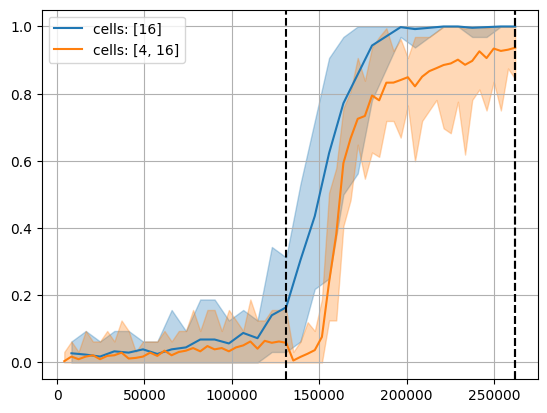

In [40]:
map_scale = 4
p = 0.8

storage_path = f"sqlite:///optuna_studies/{2**map_scale}x{2**map_scale}_p_{p}.db"
for cell_scales in [(map_scale,), (2,4,)]:
    study = optuna.load_study(study_name=f"mango_stages_{list(cell_scales)}", storage=storage_path)
    print("n_trials", len(study.trials))
    plot_accuracy_evolution(study.best_trial, label=f"cells: {[2**s for s in cell_scales]}")
plt.grid()
plt.legend()
